In [2]:
import pandas as pd
from dask import dataframe as dask_dataframe
import matplotlib.pyplot as plt

from matplotlib import rcParams
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['axes.linewidth'] = 2
rcParams['savefig.dpi'] = 850
rcParams['font.size'] = 20
import numpy as np
%config InlineBackend.figure_format = "retina"
from tqdm import tqdm
from astropy.io import ascii
import os
import sys
import astropy.stats as astro_stats
from astropy.coordinates import SkyCoord
from astropy import units as u

%matplotlib inline

# relative path to dipper code
sys.path.append('../dipper/')

In [3]:
# dipper detection pipeline
%load_ext autoreload
%autoreload 2

import dipper as dipper 
import tools as tools
from evaluate import evaluate_updated
from evaluate import half_eval

## Mock signals

In [145]:
## Parametric models: Generalized Gaussian, and Skew-Normal ##
from math import gamma
from scipy.special import erf
import astropy.stats as astro_stats

def skew_norm(x, mu, sigma, alpha, ofs, amp):
    """
    Skew-normal distribution modified with an offset term and amplitude to fit the light curves.
    
    Parameters:
    -----------
    x (array-like): Input time values.
    mu (float): Mean of the distribution.
    sigma (float): Standard deviation of the distribution.
    alpha (float): Shape parameter controlling the skewness of the distribution.
    ofs (float): Offset term.

    Returns:
    --------
    y (array-like): Output magnitude values.
    """
    gaus = 1/np.sqrt(2*np.pi) * np.exp(-(x-mu)**2/sigma**2)
    FI = 0.5 * (1 + erf(alpha*(x-mu)/np.sqrt(2)))
    return ofs + amp*2*gaus*FI

def ggd(x, mu, alpha, beta, ofs, amp):
    """
    Generalized Gaussian Distribution modified with an offset term and amplitude to fit the light curves.
    
    Parameters:
    -----------
    x (array-like): Input time values.
    mu (float): Mean of the distribution.
    alpha (float): Scale parameter (i.e SIGMA).
    beta (float): Shape parameter.
    ofs (float): Offset term.
    amp (float): Amplitude term

    Returns:
    --------
    y (array-like): Output magnitude values.
    """

    term_1 = beta/(2*alpha*gamma(1/beta))
    abs_term = ((abs(x-mu))/alpha)**beta
    mm = amp * term_1 * np.exp(-abs_term)
    return mm + ofs

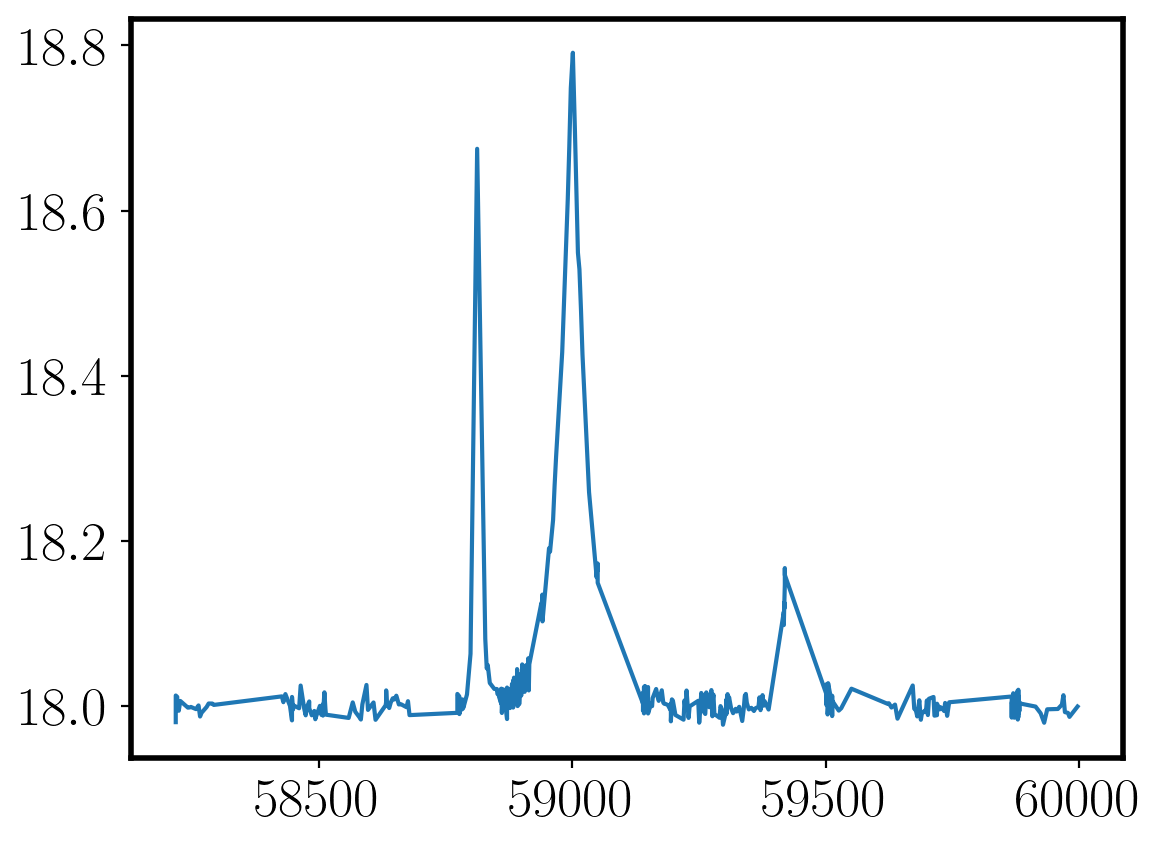

In [146]:
# times from a random ZTF field
times = ascii.read("https://ztf.snad.space/dr17/csv/574211400034900")['mjd'].value

# Simulated dipper signal
model = ggd(times, 59_000, 30, 1, 18, 50)

for j in range(3):
    model += ggd(times, 59_000+np.random.randint(-1250, 950), 5, 1, 0, np.random.randint(5, 25))

model += np.random.normal(0, 0.01, len(times)) # add noise
errs = abs(np.random.normal(0, 0.01, len(times))) # add fake errors

flt = ['r' for _ in range(len(times))]
fltg = ['g' for _ in range(len(times))]
flg = np.zeros(len(times))

plt.plot(times, model)

## Light Curve Eval

In [147]:
obs_time = np.concatenate([times, times])
obs_mag = np.concatenate([model, model])
obs_magerr = np.concatenate([errs, errs])
obs_filter = np.concatenate([flt, fltg])
obs_flags = np.concatenate([flg, flg])

11.12537036482662

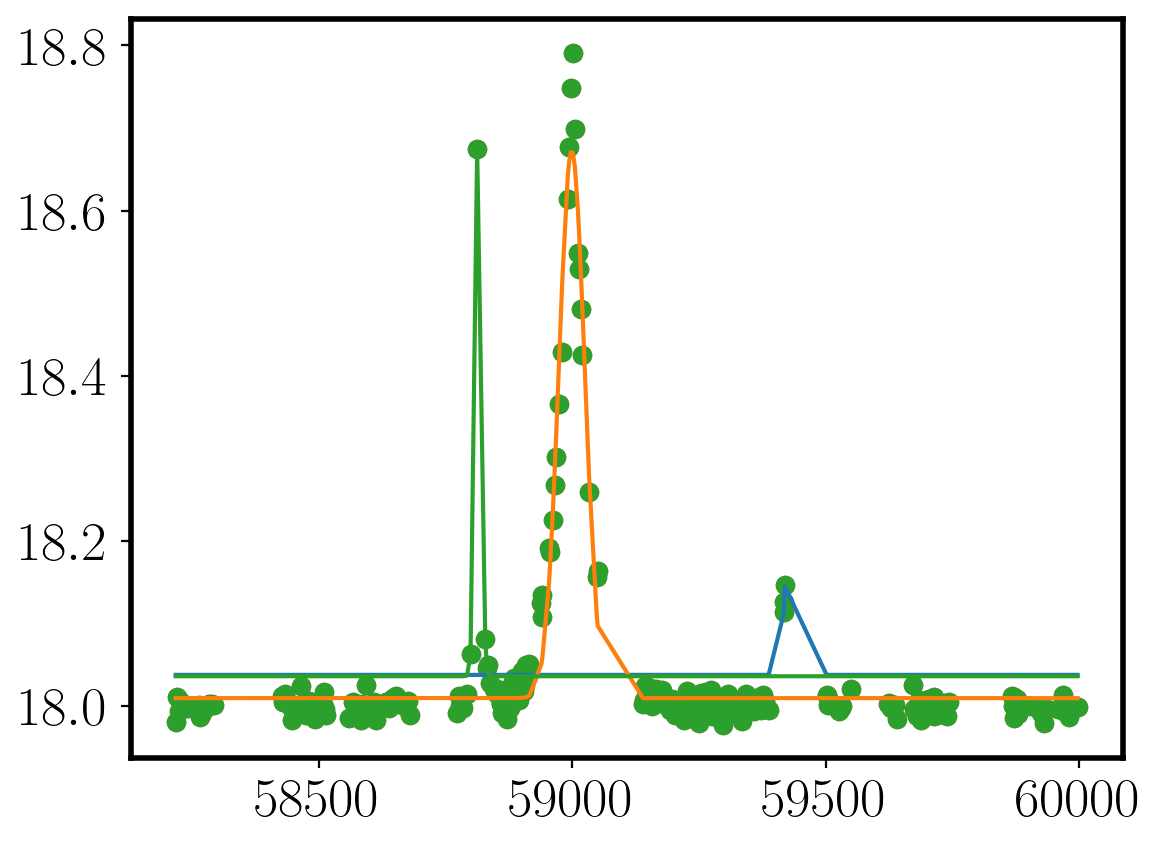

In [148]:
np.log(evaluate_updated(obs_time, obs_mag, obs_magerr, obs_flags, obs_filter)['lc_score'])

Nphot                    275.000000
biweight_scale             0.013820
frac_above_2_sigma         0.047273
Ndips                      3.000000
rate                       0.001687
chi2dof                    1.078244
skew                       4.125963
kurtosis                  17.195123
mad                        0.009262
stetson_i             211474.850950
stetson_j               1924.751106
stetson_k                  0.261509
invNeumann                 0.769437
best_dip_power            55.049041
best_dip_time_loc      59001.228510
best_dip_start         58974.234030
best_dip_end           59048.167240
best_dip_dt                0.000000
best_dip_ndet             11.000000
lc_score               67871.423597
dtype: float64

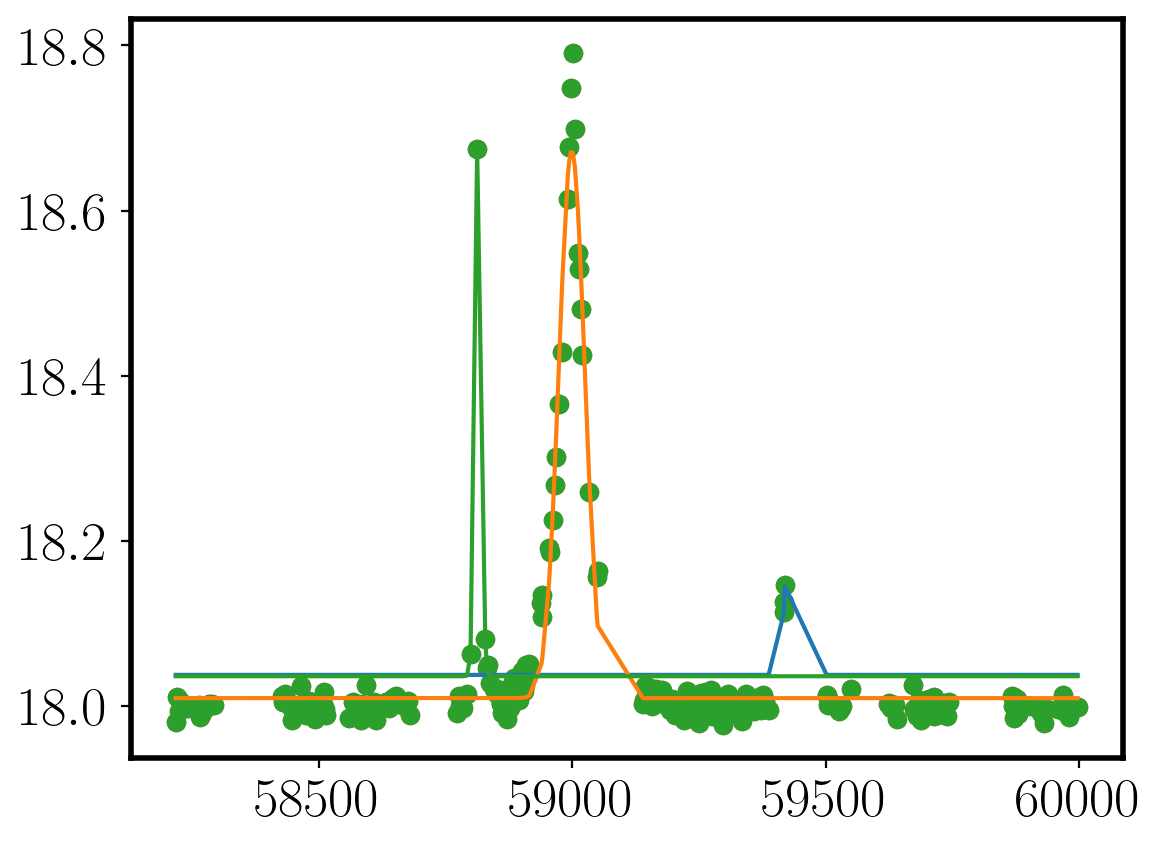

In [149]:
evaluate_updated(obs_time, obs_mag, obs_magerr, obs_flags, obs_filter)

## Real ZTF Candidate Example

In [150]:
lc_r =  ascii.read("https://ztf.snad.space/dr17/csv/708201200001443")
lc_g = ascii.read("https://ztf.snad.space/dr17/csv/708101200003967")

In [151]:
lc_time = np.concatenate([lc_r['mjd'].value, lc_g['mjd'].value])
lc_mag = np.concatenate([lc_r['mag'].value, lc_g['mag'].value])
lc_magerr = np.concatenate([lc_r['magerr'].value, lc_g['magerr'].value])
lc_filter = np.concatenate([['r' for _ in range(len(lc_r))], ['g' for _ in range(len(lc_g))]])
lc_flags = np.zeros(len(lc_time))

Text(0.5, 0, 'Time (MJD)')

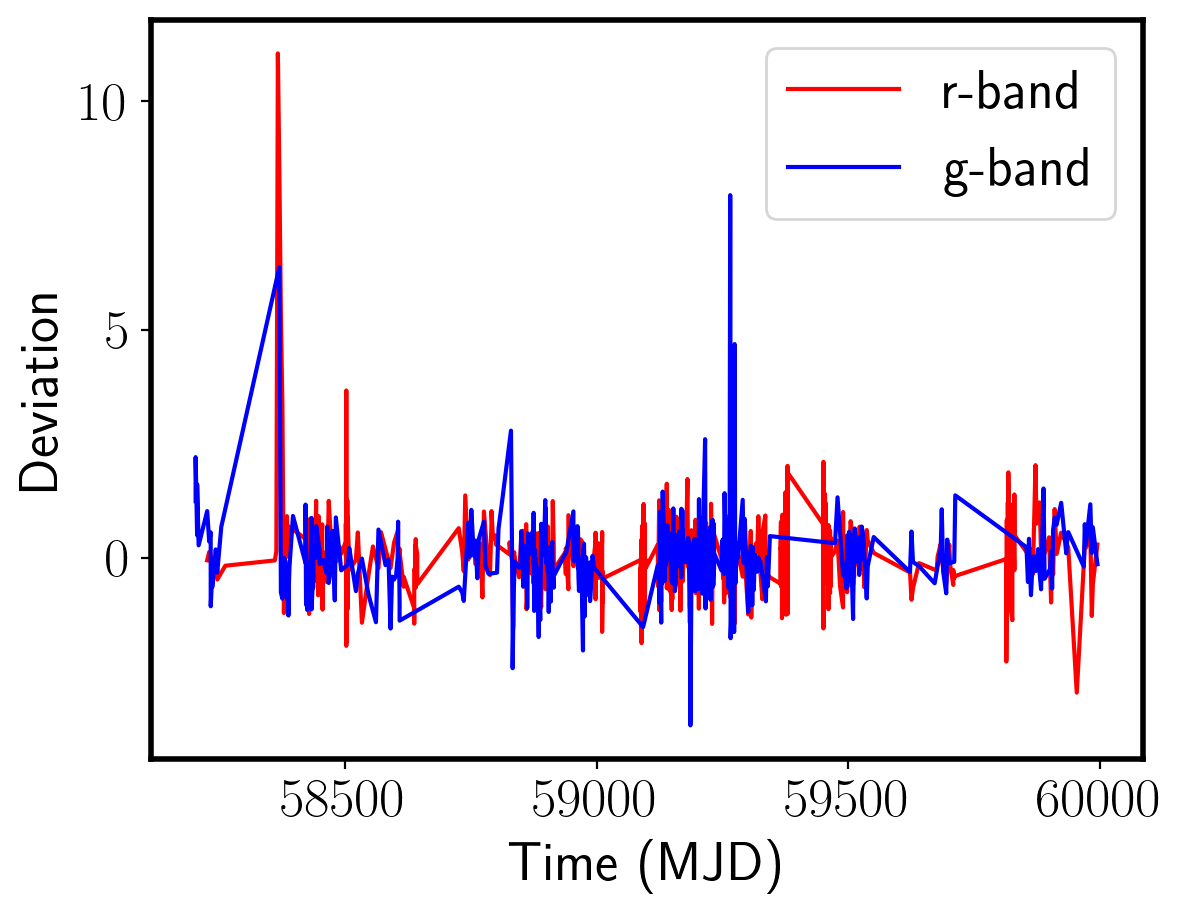

In [152]:
dev_r = dipper.deviation(lc_r['mag'], lc_r['magerr'], np.median(lc_r['mag']), np.std(lc_r['mag']))
dev_g = dipper.deviation(lc_g['mag'], lc_g['magerr'], np.median(lc_g['mag']), np.std(lc_g['mag']))

plt.plot(lc_r['mjd'], dev_r, label='r-band', color='red')
plt.plot(lc_g['mjd'], dev_g, label='g-band', color='b')
plt.legend()
plt.ylabel('Deviation')
plt.xlabel('Time (MJD)')

11.307403347722024

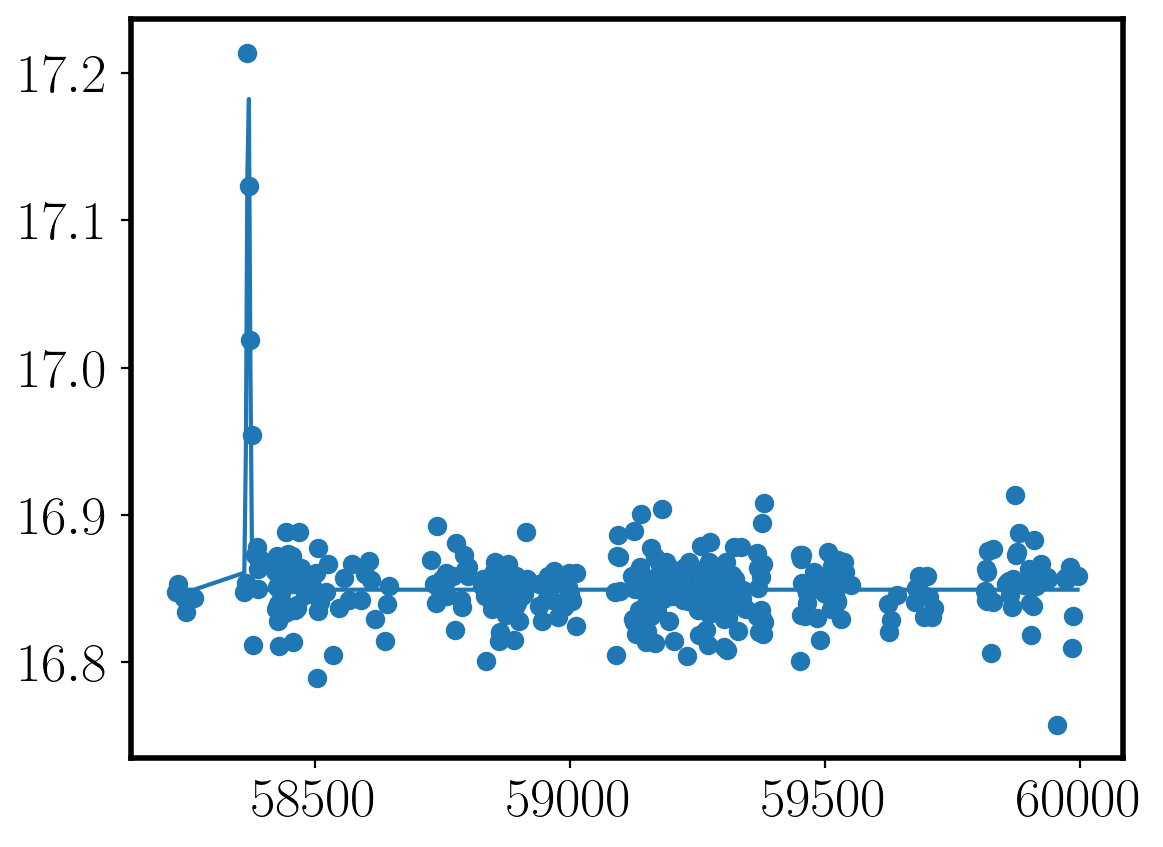

In [153]:
np.log(evaluate_updated(lc_time, lc_mag, lc_magerr, lc_flags, lc_filter)['lc_score'])